# Численный анализ сценариев: имитационный и аналитический подходы

В этом ноутбуке мы исследуем эффективность аналитической модели и сравним ее точность с имитационной моделью RFID.

Мы сравним и изучим три характеристики:

- распределение числа активных меток по раундам;
- оценки длительностей раундов;
- вероятность идентификации отдельной метки.

Первые две характеристики мы аналитически получим с помощью фонового процесса, а третью - с помощью основного процесса.

## Настройка ноутбука

Сначала подключим все нужные нам библиотеки, определим простые служебные функции и настроим библиотеку `matplotlib`.

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Раскоментируйте следующие строки, чтобы установить нужные библиотеки:
#!pip install matplotlib
#!pip install tabulate

In [110]:
import os
import itertools                 # декартово произведение списков (product)
import numpy as np
import pandas as pd              # нужна для работы с данными моделирования
import matplotlib as mpl
import matplotlib.pyplot as plt  # графики
from tqdm.notebook import tqdm   # с помощью tqdm будем изображать прогресс
from typing import Dict, Any

from rfidam.simulation import ModelParams, build_scenario_info
from rfidam.chains import estimate_rounds_props, estimate_id_probs
from rfidam.cy_ext.simulation import simulate
from rfidam.protocol.protocol import LinkProps, Protocol
from rfidam.protocol import symbols
from rfidam.scenario import parse_scenario, mark_scenario
from rfidam.statistics import count_averages, group_round_values, StatsVector
from rfidam.utils import bcolors, get_err, fmt_err, highlight as hl, pluralize

In [123]:
%matplotlib inline
# Настроим Matplotlib: выберем цветовую схему и сделаем шрифты крупнее
CMAP = plt.get_cmap('viridis')
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20

Определим функции для форматирования вывода:

In [9]:
def fmt_header(s): return highlight(s, bcolors.OKBLUE)
def fmt_delim(s): return highlight(s, bcolors.OKCYAN)
def fmt_float(x): return f'{x:.4f}' 

## Параметры окружения

Все параметры, которые нам понадобятся в этом эксперименте, можно разделить на три группы:

- *гиперпараметры*: настройки (гиперпараметры) алгоритмов
- *метапараметры*: параметры модели, значения которых не существенно влияют на результаты, или 
- *свободные (переменные) параметры*: параметры, изменение которых наиболее существенно влияет на результаты

К *гиперпараметрам* относится, например, число моделируемых меток, или кратность расширенных сценариев. Такие параметры влияют на точность результатов и скорость расчетов.


*Метапараметры* - это те величины, которые сами по себе не оказывают существенного влияния на результаты, и для их различных значений можно подобрать диапазоны других (мета- и обычных) параметров, на которых будут получены близкие результаты. Например, так как в модели явно задается BER, то параметр `M` (число символов на бит в ответах меток) влияет только на длительность сообщений, поэтому, если для `M=8` взять большую область чтения и увеличить интервал между метками пропорционально, то можно получить тот же результат, что и для `M=1`, маленькой области чтения и коротких интервалов между поступлениями.
Большинство настроек RFID попадают в категорию метапараметров из-за того, что BER - свободный параметр.

*Свободные параметры* - это те параметры, которые наиболее существенно влияют на результат. К ним относятся сценарии работы считывателя, BER и интервалы между поступлениями меток.

### Гиперпараметры и настройки

В модели используется три гиперпараметра:

- число моделируемых меток;
- кратность расширенных сценариев;
- множитель раундов при свертке.

Кратность расширенных сценариев определяет, сколько раз копируется сценарий при построении расширенного сценария. Например, если сценарий задается строкой `"ABABx"`, а кратность равна пяти, то расширенный сценарий будет `"ABABxABABxABABxABABxABABx"`. Чем выше кратность, тем больше моментов поступления и выхода меток попадет в моделируемый (аналитической моделью) интервал, и тем точнее будет результат. Однако при этом растет сложность расчета.

Число моделируемых меток определяет, сколько событий поступлений новых меток будет моделироваться в имитации.

Множитель при свертке сценариев используется при исследовании характеристик раундов, там он будет описан подробнее.

> **ВНИМАНИЕ!** После загрузки из CSV гиперпараметры могут быть изменены на значения из файла.

In [37]:
N_SIM_TAGS = 5000           # число моделируемых меток
EXT_SCENARIO_MULT = 1000    # кратность расширенных сценариев
ROLL_SCENARIO_KOEF = 3      # множитель длины сценарии при свертывании

Также определим настройки исполнения модели:

- имя CSV-файла, из которого будут браться готовые данные (если он есть), или в который будут записаны результаты моделирования;
- флаг `FORCE_COMPUTE`, указывающий, что результаты надо обязательно пересчитать, независимо от того, существует ли CSV-файл;
- число рабочих (параллельных процессов), которые будут использоваться при моделировании.

Очень желательно делать число рабочих равным или немного меньшим числа ядер процессора.

Если флаг `FORCE_COMPUTE = False` и CSV-файл существует, то модели не будут пересчитываться, а данные и диапазоны свободных параметров будут загружены из файла.

In [15]:
CSV_FILE_NAME = os.path.join("data", "id_prob.csv")
FORCE_COMPUTE = False       # <-- !! Если True, то пересчитать все !!
N_WORKERS = 8               # число параллельных процессов

### Метапараметры

Метапараметры не влияют на результаты моделирования сами по себе, их значения влияют только на диапазон свободных параметров. К метапараметрам относятся:

- параметры передачи команд считывателя `Tari`, `RTcal`, `TRcal`
- параметры передачи ответов меток `M`, `DR`, `TREXT`
- длительность отключения считывателя `T_OFF`
- время нахождения метки в области чтения `TIME_IN_AREA`
- число читаемых слов из TID `N_DATA_WORDS` и размер EPCID в байтах `N_EPCID_BYTES`
- показатель числа слотов `Q`

> **ЗАМЕЧЕНИЕ.** Если бы BER не был свободным параметром (например, свободным параметром был бы SNR), то параметры `Tari`, `M`, `DR`, `TREXT` оказывали бы более существенное влияние, так как от них бы зависел BER. С другой стороны, это изменение также можно было бы скомпенсировать изменение диапазона `SNR`, хотя это было бы не столь реалистично, и правильней было бы сделать эти параметры свободными.

Величина Q влияет на вероятность коллизий, как и число меток в области чтения, а последнее зависит от свободного параметра `ARRIVAL_INTERVALS`. Остальные параметры считывателя и меток влияют на длительности передачи и простоя, и могут компенсироваться изменением `TIME_IN_AREA` и пропорциональным изменением значений `ARRIVAL_INTERVLAS`.

> **ВНИМАНИЕ!** После загрузки из CSV метапараметры могут быть изменены на значения из файла.

In [39]:
# Настройки считывателя
TARI = 12.5e-6        # Tari = Data-0 в командах считывателя
RTCAL = 3 * TARI      # Reader-Tag Calibration
TRCAL = 1.5 * RTCAL   # Tag-Reader Calibration
Q = 2                 # число слотов = 2^Q
T_OFF = .1            # длительность отключения

# Параметры передачи ответов меток
M = symbols.TagEncoding.M2  # число символов на бит
DR = symbols.DR.DR_643      # division ratio
TREXT = False               # использовать ли расширенную преамбулу
N_DATA_WORDS = 4            # число слов (16 бит) в TID
N_EPCID_BYTES = 12          # число байт (8 бит) в EPCID

# Параметры мобильности
TIME_IN_AREA = 2.5     # длительность нахождения метки в области чтения

Так как свойства протокола (`rfidam.protocol.LinkProps`) полностью определяются метапараметрами, создадим здесь объекты, представляющие протокол, и будем использовать их везде далее.

In [40]:
PROPS_KWARGS = {
    'tari': TARI, 
    'rtcal': RTCAL,
    'trcal': TRCAL,
    'm': M,
    'dr': DR,
    'trext': TREXT,
    'q': Q,
    't_off': T_OFF,
    'n_data_words': N_DATA_WORDS,
    'n_epcid_bytes': N_EPCID_BYTES,
}
PROTOCOL_EPC = Protocol(LinkProps(**PROPS_KWARGS, use_tid=False))
PROTOCOL_TID = Protocol(LinkProps(**PROPS_KWARGS, use_tid=True))

### Свободные параметры

Мы определим три свободных параметра:

- интервал между поступлениями меток (метки поступают через равные интервалы);
- сценарий работы считывателя;
- вероятность битовой ошибки (BER).

Интервал между поступлениями определяет максимальное число меток в системе как `ceil(TIME_IN_AREA / ARRIVAL_INTERVALS) + 1`.

Сценарии задаются строками типа `ABABx`, где `A` или `B` - флаг опроса в раунде, а если за флагом идет `x`, то после раунда считыватель отключается.

> **ВНИМАНИЕ!** После загрузки из CSV метапараметры могут быть изменены на значения из файла.

In [38]:
ARRIVAL_INTERVALS = [
    0.2,  # очень короткий интервал: 13 меток в системе
    0.4,  # высокая загрузка: 7 меток в системе
    1.0   # низкая загрузка: 2 метки в системе
]

SCENARIOS = [
    "Ax", "AAx", "AAAAx",         # периодические отключения
    "AB", "AABB", "AAAABBBB",     # периодические смены флага
    "A",                          # самый плохой случай - "всегда A"
    "AAABxAAxABABx"               # сложный нетривиальный случай
]

BER_MIN = .001       # минимальное значение BER
BER_MAX = .05        # максимальное значение BER
N_BER_POINTS = 21    # размер сетки

BER = np.linspace(BER_MIN, BER_MAX, N_BER_POINTS)

## Характеристики раундов

Вычислим оценки характеристик раундов с помощью имитационной и аналитической модели. Мы будем исследовать три характеристики:

- число меток, участвующих в раунде (активных меток);
- длительности раундов;
- вероятность идентификации метки, поступившей в `i`-м раунде.

И при имитационном, и при аналитическом моделировании на самом деле рассматривается очень много раундов. С одной стороны, нет смысла сравнивать значения в каждом из раундов (слишком большая случайность), с другой - между значениями на одинаковых смещениях от начала сценария должна быть связь. Поэтому мы будем сравнивать значения характеристик, усредненные по всем раундам с одинаковым смещением от начала сценария. 

Так как сами сценарии могут быть очень короткими, а события попадания и выхода меток могут попадать в раунды с разными смещениями, будем рассматривать не сами сценарии, а их небольшие расширения. Коэффициент умножения сценариев будем называть *множителем при свертке*: по смыслу, если представить все значения в виде вектора-строки, мы "сворачиваем" его как ленту в таблицу с заданным числом столбцов, и проводим усреднение по каждому столбцу:

```
x1, x2, x3, x4, ..., xN
     ||
     vv
+-----------+-----------+-----+-------+
| x1        | x2        | ... | xK    |
+-----------+-----------+-----+-------+
| x[K+1]    | x[K+2]    | ... | x[2K] |
+-----------+-----------+-----+-------+
| ...       | ...       | ... | ...   |
+-----------+-----------+-----+-------+
| x[N-K]    | x[N-K+1]  | ... | xN    |
+-----------+-----------+-----+-------+
     ||
     vv
+-----------+-----------+-----+-----------+     
| (x1 +     | (x2 +     |     | (xK +     |
|  x[K+1] + |  x[K+2] + |     |  x[2K] +  |
|  ...      |  ...      | ... |  ...      |
|  x[N-K]   |  x[N-K+1] |     |  xN       |
| ) / (N/K) | ) / (N/K) |     | ) / (N/K) |
+-----------+-----------+-----+-----------+
```

В этом примере в роли `xi` могут выступать число активных меток, длительность раунда или вероятность идентификации, `N` - число промоделированных раундов, а `K` - параметр сворачивания. Он равен длине сценария, умноженной на множитель при свертке `ROLL_SCENARIO_KOEF`.

In [79]:
def simulate_round_props(scenario: str, ber: float, interval: float,
                         n_iters: int = 3):
    """
    Получить оценки характеристик раундов с помощью имитационной модели.
    """
    params = ModelParams(
        protocol=PROTOCOL_TID, 
        arrival_interval=interval,
        time_in_area=TIME_IN_AREA,
        scenario=parse_scenario(scenario),
        ber=ber)
    
    print(hl("* running simulations", bcolors.OKCYAN))
    journals = [
        simulate(params, only_id=False, n_tags=N_SIM_TAGS) 
        for _ in tqdm(range(n_iters), leave=False)
    ]
    
    print(hl("* rolling results", bcolors.OKCYAN))
    size = len(params.scenario) * ROLL_SCENARIO_KOEF
    infos = build_scenario_info(journals, size)
    
    print(hl("OK!", bcolors.OKGREEN))
    return {
        'durations': infos.round_durations,
        'n_tags': infos.num_tags_active,
        'p_id': infos.id_probs
    }

In [80]:
def solve_round_props(scenario: str, ber: float, interval: float):
    """
    Получить оценки характеристик раундов с помощью аналитической модели.
    """
    parsed_scenario = parse_scenario(scenario)
    extended_scenario = parsed_scenario * EXT_SCENARIO_MULT
    size = len(parsed_scenario) * ROLL_SCENARIO_KOEF
    
    props = estimate_rounds_props(
        scenario=extended_scenario,
        protocol=PROTOCOL_TID,
        ber=ber,
        arrival_interval=interval,
        time_in_area=TIME_IN_AREA)

    marked_scenario = mark_scenario(
        scenario=extended_scenario, 
        arrival_interval=interval, 
        time_in_area=TIME_IN_AREA, 
        durations=props['durations'], 
        t0=(interval * 100.5))

    _, id_probs_map = estimate_id_probs(
        n_tags_probs=props['n_active_tags'],
        scenario=marked_scenario,
        durations=props['durations'],
        ber=ber,
        protocol=PROTOCOL_TID,
        time_in_area=TIME_IN_AREA
    )
    
    # estimate_id_probs() возвращает словарь типа 
    #   "номер раунда" -> вероятность идентификации
    p_id = list(list() for _ in range(size))
    for offset, p in id_probs_map.items():
        p_id[offset % size].append(p)
    
    return {
        'durations': \
            count_averages(group_round_values(props['durations'], size)),
        'n_tags': count_averages(
            group_round_values(
                [p @ np.arange(p.shape[0]) for p in props['n_active_tags']], 
                size
            )),
        'p_id': count_averages(p_id)
    }    

Вычислим с помощью имитационной и аналитической моделей характеристики для двух различных сценариев:

- `ABABx`
- `AAABxAAxABABx`

В обоих случаях будем полагать BER = 0.01, а интервал между метками равным 0.5.

In [107]:
round_props = {}
for scenario in tqdm(['ABABx', 'AAABxAAxABABx'], leave=True):
    round_props[scenario] = {}
    
    print(hl(f"[>] analytics for '{scenario}'", bcolors.BOLD))
    round_props[scenario]['ana'] = \
        solve_round_props(scenario, ber=0.01, interval=0.5)
    
    print(hl(f"[>] simulation for '{scenario}'", bcolors.BOLD))
    round_props[scenario]['sim'] = \
        simulate_round_props(scenario, ber=0.01, interval=0.5)
    print(hl(f"[=] FINISHED.", bcolors.BOLD))

  0%|          | 0/2 [00:00<?, ?it/s]

[>] analytics for 'ABABx'
[>] simulation for 'ABABx'
* running simulations


  0%|          | 0/3 [00:00<?, ?it/s]

* rolling results
OK!
[=] FINISHED.
[>] analytics for 'AAABxAAxABABx'
[>] simulation for 'AAABxAAxABABx'
* running simulations


  0%|          | 0/3 [00:00<?, ?it/s]

* rolling results
OK!
[=] FINISHED.


Построим графики, чтобы наглядно увидеть, насколько различаются результаты.

In [178]:
def plot_round_props(round_props, scenario, show_title=False, save=False, fmt='png'):
    data = round_props[scenario]
    fig, axes = plt.subplots(figsize=(16, 5), ncols=3, nrows=1)
    
    def plot_metric(ax, metric, scale=None, ylabel=''):
        if isinstance(sim[metric], StatsVector):
            y_sim = sim[metric].means
            y_err = sim[metric].errors
        else:
            y_sim = sim[metric]
            y_err = None
        y_ana = ana[metric].means
        ax.plot(ox, y_sim, marker='o', markersize=8, linestyle='--', color='b',
                label='Симуляция')
        ax.plot(ox, y_ana, marker='x', markersize=8, linestyle=':', color='r',
                label='Аналитика')
        if y_err is not None:
            ax.fill_between(ox, y_sim - y_err, y_sim + y_err, facecolor='g', alpha=0.2)
        if scale is not None:
            ax.set_yscale('log')
        ax.grid()
        ax.set_ylabel(ylabel)
        
    sim = data['sim']
    ana = data['ana']
    ox = np.arange(len(parse_scenario(scenario)) * ROLL_SCENARIO_KOEF)
    plot_metric(axes[0], 'durations', scale='log', ylabel='Время, сек.')
    plot_metric(axes[1], 'n_tags', ylabel='Число меток')
    plot_metric(axes[2], 'p_id', ylabel='Вероятность')

    axes[0].set_title('Длительности раундов')
    axes[1].set_title('Число активных меток')
    axes[2].set_title('Вероятность идентификации')    
    for col in range(3):
        axes[col].set_xlabel("Номер раунда")
    
    axes[-1].legend(loc='upper right', ncol=1)
    
    if show_title:
        fig.suptitle(f'Характеристики раундов для сценария {scenario}')

    plt.tight_layout()
    if save:
        plt.savefig(os.path.join('images', f'round_props_{scenario}.{fmt}'))

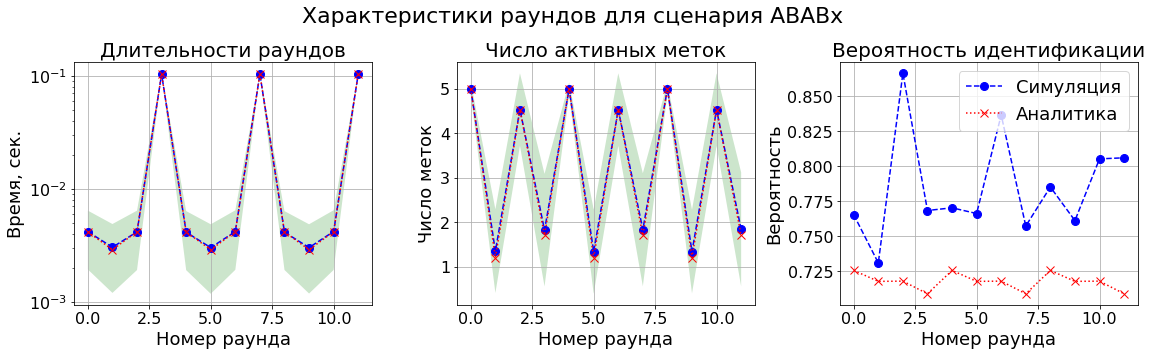

In [180]:
plot_round_props(round_props, "ABABx", show_title=True, save=False)

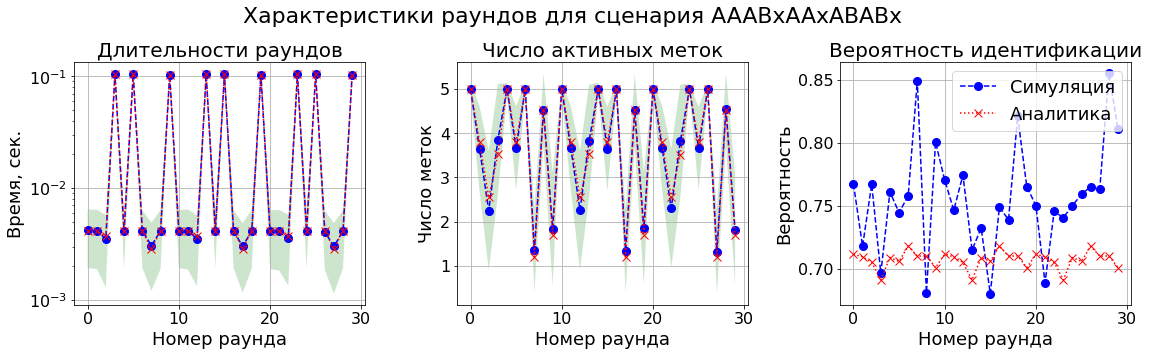

In [182]:
plot_round_props(round_props, "AAABxAAxABABx", show_title=True, save=False)

# Расчет зависимости идентификации от BER

In [67]:
import os
import pandas as pd


will_run = not os.path.exists(FILE_NAME) or FORCE_COMPUTE

if will_run:
    print(f"File {FILE_NAME}{' ' if os.path.exists(FILE_NAME) else ' not'} found, FORCE_COMPUTE={FORCE_COMPUTE}. "
          f"File will be generated, simulations and estimations will be executed.")
else:
    print(f"File {FILE_NAME} found, it will be used without running simulations.")

File data/id_prob.csv found, it will be used without running simulations.


Определим параметры, которые не будут меняться между симуляциями. К таким параметрам относится все, что касается линков `R => T` и `T => R`:
так как в нашей модели BER фиксируется, то увеличение `Tari` или `M` приведет только к увеличению длины раунда (и уменьшению числа раундов),
но не будет влиять на BER, поэтому их учет не даст полезной информации. 

Выбранные параметры приблизительно соответствуют тем, которые используются в эксперименте.

> **ВНИМАНИЕ! Эти параметры не сохраняются в CSV-файле, поэтому после их изменения нужно явно сказать, что экспермент нужно пересчитать.**

In [68]:
from rfidam.protocol import symbols



Теперь определим параметры, которые будут меняться. Это:

- интервалы между поступлениями меток
- BER
- сценарии

In [74]:
import itertools

if will_run:
    
    df = pd.DataFrame([
        {
            'ber': ber,
            'interval': interval,
            'scenario': scenario,
            'id_type': id_type,
            'p_sim': 0.0,
            'p_ana': 0.0,
        }
        for ber, interval, scenario, id_type in itertools.product(BER, ARRIVAL_INTERVALS, SCENARIOS, ["EPCID", "TID"])
    ])
    df.to_csv(FILE_NAME, index=False)
    
    # Execute simulation:
    print(f"[*] running {len(df)} simulations")
    %run ../rfidam/main.py batch simulate $FILE_NAME --jupyter \
        -j $N_WORKERS --num-tags $N_SIM_TAGS \
        --tari $TARI --rtcal $RTCAL --trcal $TRCAL \
        -q $Q --tag-encoding $M.value \
        --dr $DR_S --time-in-area $TIME_IN_AREA --time-off $T_OFF
    
    # Execute analytic estimations:
    print(f"[*] running {len(df)} analytic estimations")
    %run ../rfidam/main.py batch solve $FILE_NAME --jupyter \
        -j $N_WORKERS --ext-mul $SCENARIO_MULTIPLIER \
        --tari $TARI --rtcal $RTCAL --trcal $TRCAL \
        -q $Q --tag-encoding $M.value \
        --dr $DR_S --time-in-area $TIME_IN_AREA --time-off $T_OFF
    
    df = pd.read_csv(FILE_NAME)
    
else:
    # Если CSV-файл существует, то мы получаем все сценарии, интервалы и 
    # значения BER из этого файла
    df = pd.read_csv(FILE_NAME)
    ARRIVAL_INTERVALS = list(df.interval.unique())
    SCENARIOS = list(df.scenario.unique())
    BER = list(df.ber.unique())
    ARRIVAL_INTERVALS.sort()
    BER.sort()    

In [83]:


def plot_id_probs(scenario, show_suptitle=False, save=False, fmt="pdf"):
    n_intervals = len(ARRIVAL_INTERVALS)
    
    _df = df[df.scenario == scenario]
    _dfs_tid, _dfs_epc = [], []
    for interval in ARRIVAL_INTERVALS:
        _dfs_tid.append(_df[(_df.interval == interval) & (_df.id_type == "TID")])
        _dfs_epc.append(_df[(_df.interval == interval) & (_df.id_type == "EPCID")])
    
    fig, axes = plt.subplots(figsize=(16, 4), ncols=n_intervals, nrows=1, sharey=True)
    
    sim_epc_kwargs = {'linestyle': '', 'marker': 'v', 'markersize': 6, 'color': CMAP(0.2)}
    sim_tid_kwargs = {'linestyle': '', 'marker': '^', 'markersize': 6, 'color': CMAP(0.8)}
    ana_epc_kwargs = {'linestyle': '--', 'color': CMAP(0.2)}
    ana_tid_kwargs = {'linestyle': '-', 'color': CMAP(0.8)}
    
    axes[0].set_ylabel("Вероятность", fontsize=16)
    for i, interval in enumerate(ARRIVAL_INTERVALS):
        _dt, _de = _dfs_tid[i], _dfs_epc[i]
        axes[i].plot(_dt.ber, _dt.p_ana, **ana_tid_kwargs, label="TID (аналитика)")
        axes[i].plot(_dt.ber, _dt.p_sim, **sim_tid_kwargs, label="TID (симуляция)")
        axes[i].plot(_de.ber, _de.p_ana, **ana_epc_kwargs, label="EPCID (аналитика)")
        axes[i].plot(_de.ber, _de.p_sim, **sim_epc_kwargs, label="EPCID (симуляция)")

        axes[i].set_title(f"Интервал {interval} сек.", fontsize=18)
        axes[i].tick_params(labelsize=14)
        axes[i].set_xlabel("BER", fontsize=16)
        axes[i].grid()
        
    axes[-1].legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=16, ncol=1)
    
    if show_suptitle:
        fig.suptitle(f'Вероятность идентификациии для сценария "{scenario}"', fontsize=22)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(f"id_prob_{scenario}.{fmt}")

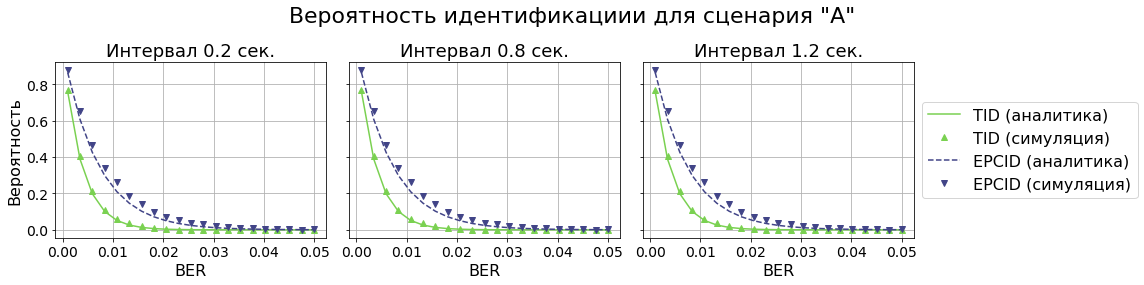

In [84]:
plot_id_probs("A", show_suptitle=True, save=False)

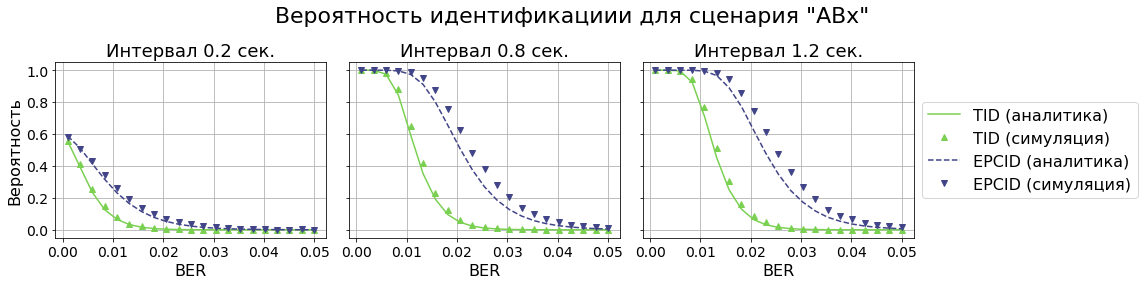

In [86]:
plot_id_probs("ABx", show_suptitle=True, save=False)

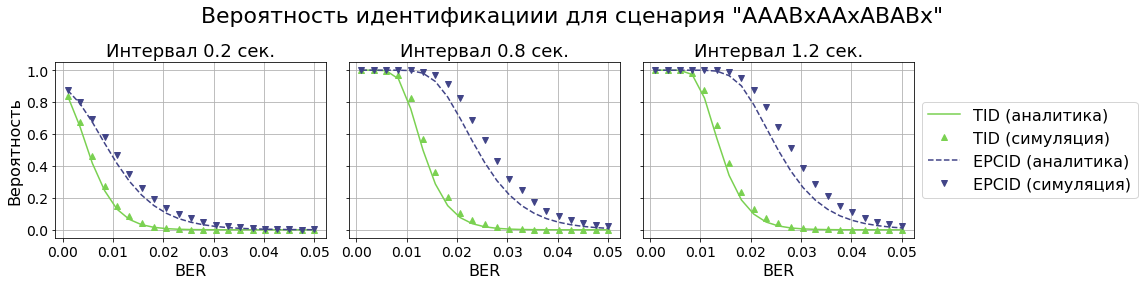

In [87]:
plot_id_probs("AAABxAAxABABx", show_suptitle=True, save=False)

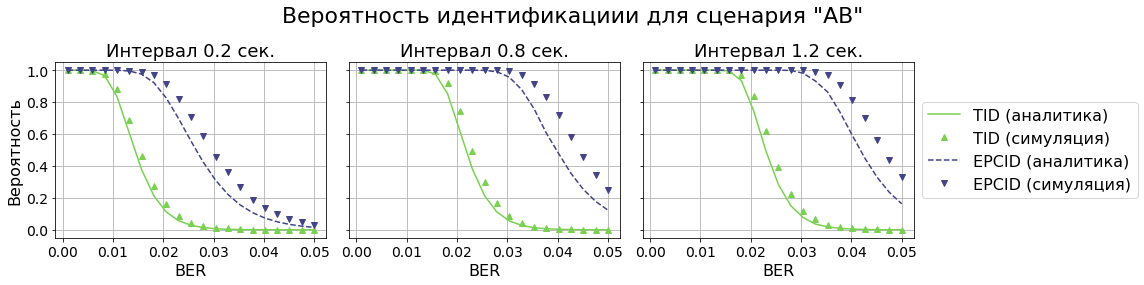

In [102]:
plot_id_probs("AB", show_suptitle=True, save=False)

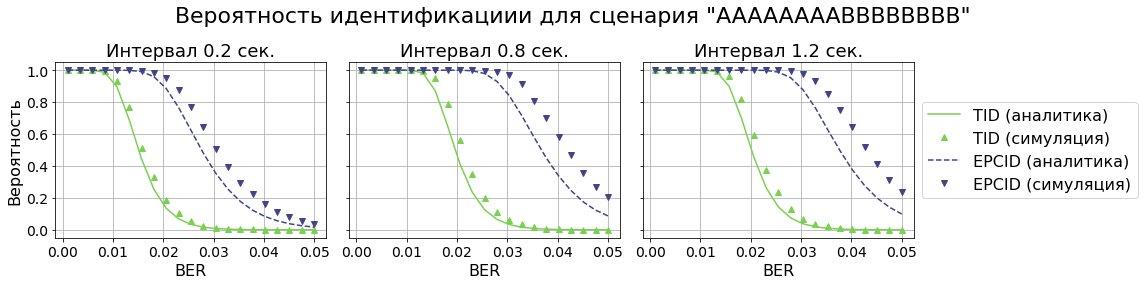

In [103]:
plot_id_probs("AAAAAAAABBBBBBBB", show_suptitle=True, save=False)

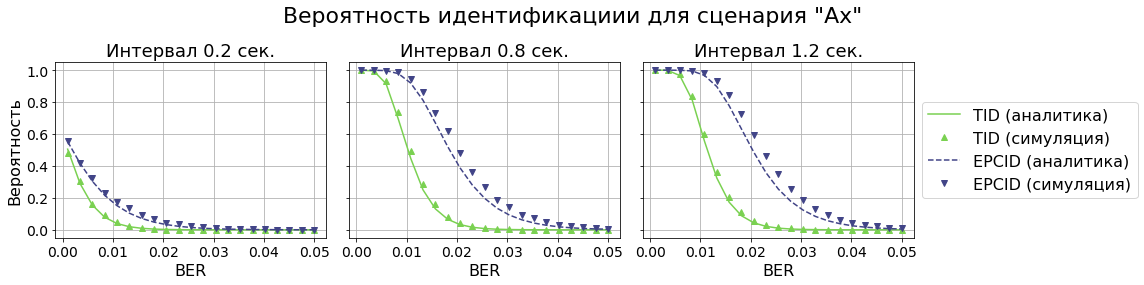

In [104]:
plot_id_probs("Ax", show_suptitle=True, save=False)

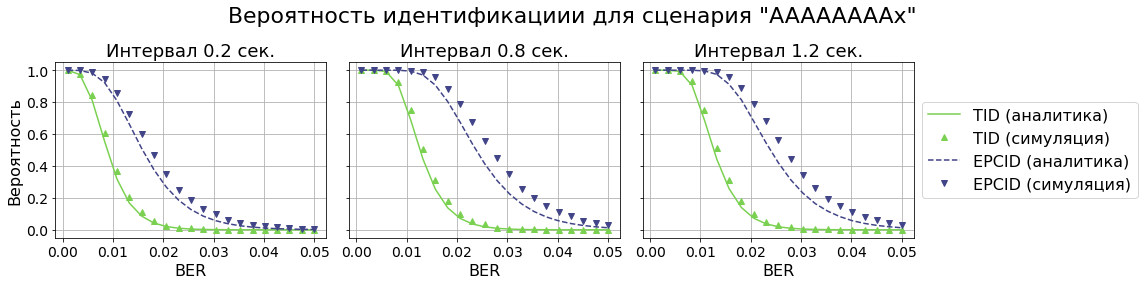

In [105]:
plot_id_probs("AAAAAAAAx", show_suptitle=True, save=False)